Array shape (rows, cols): (657, 686)
Example cell value at a node: 0.5 empty: -inf


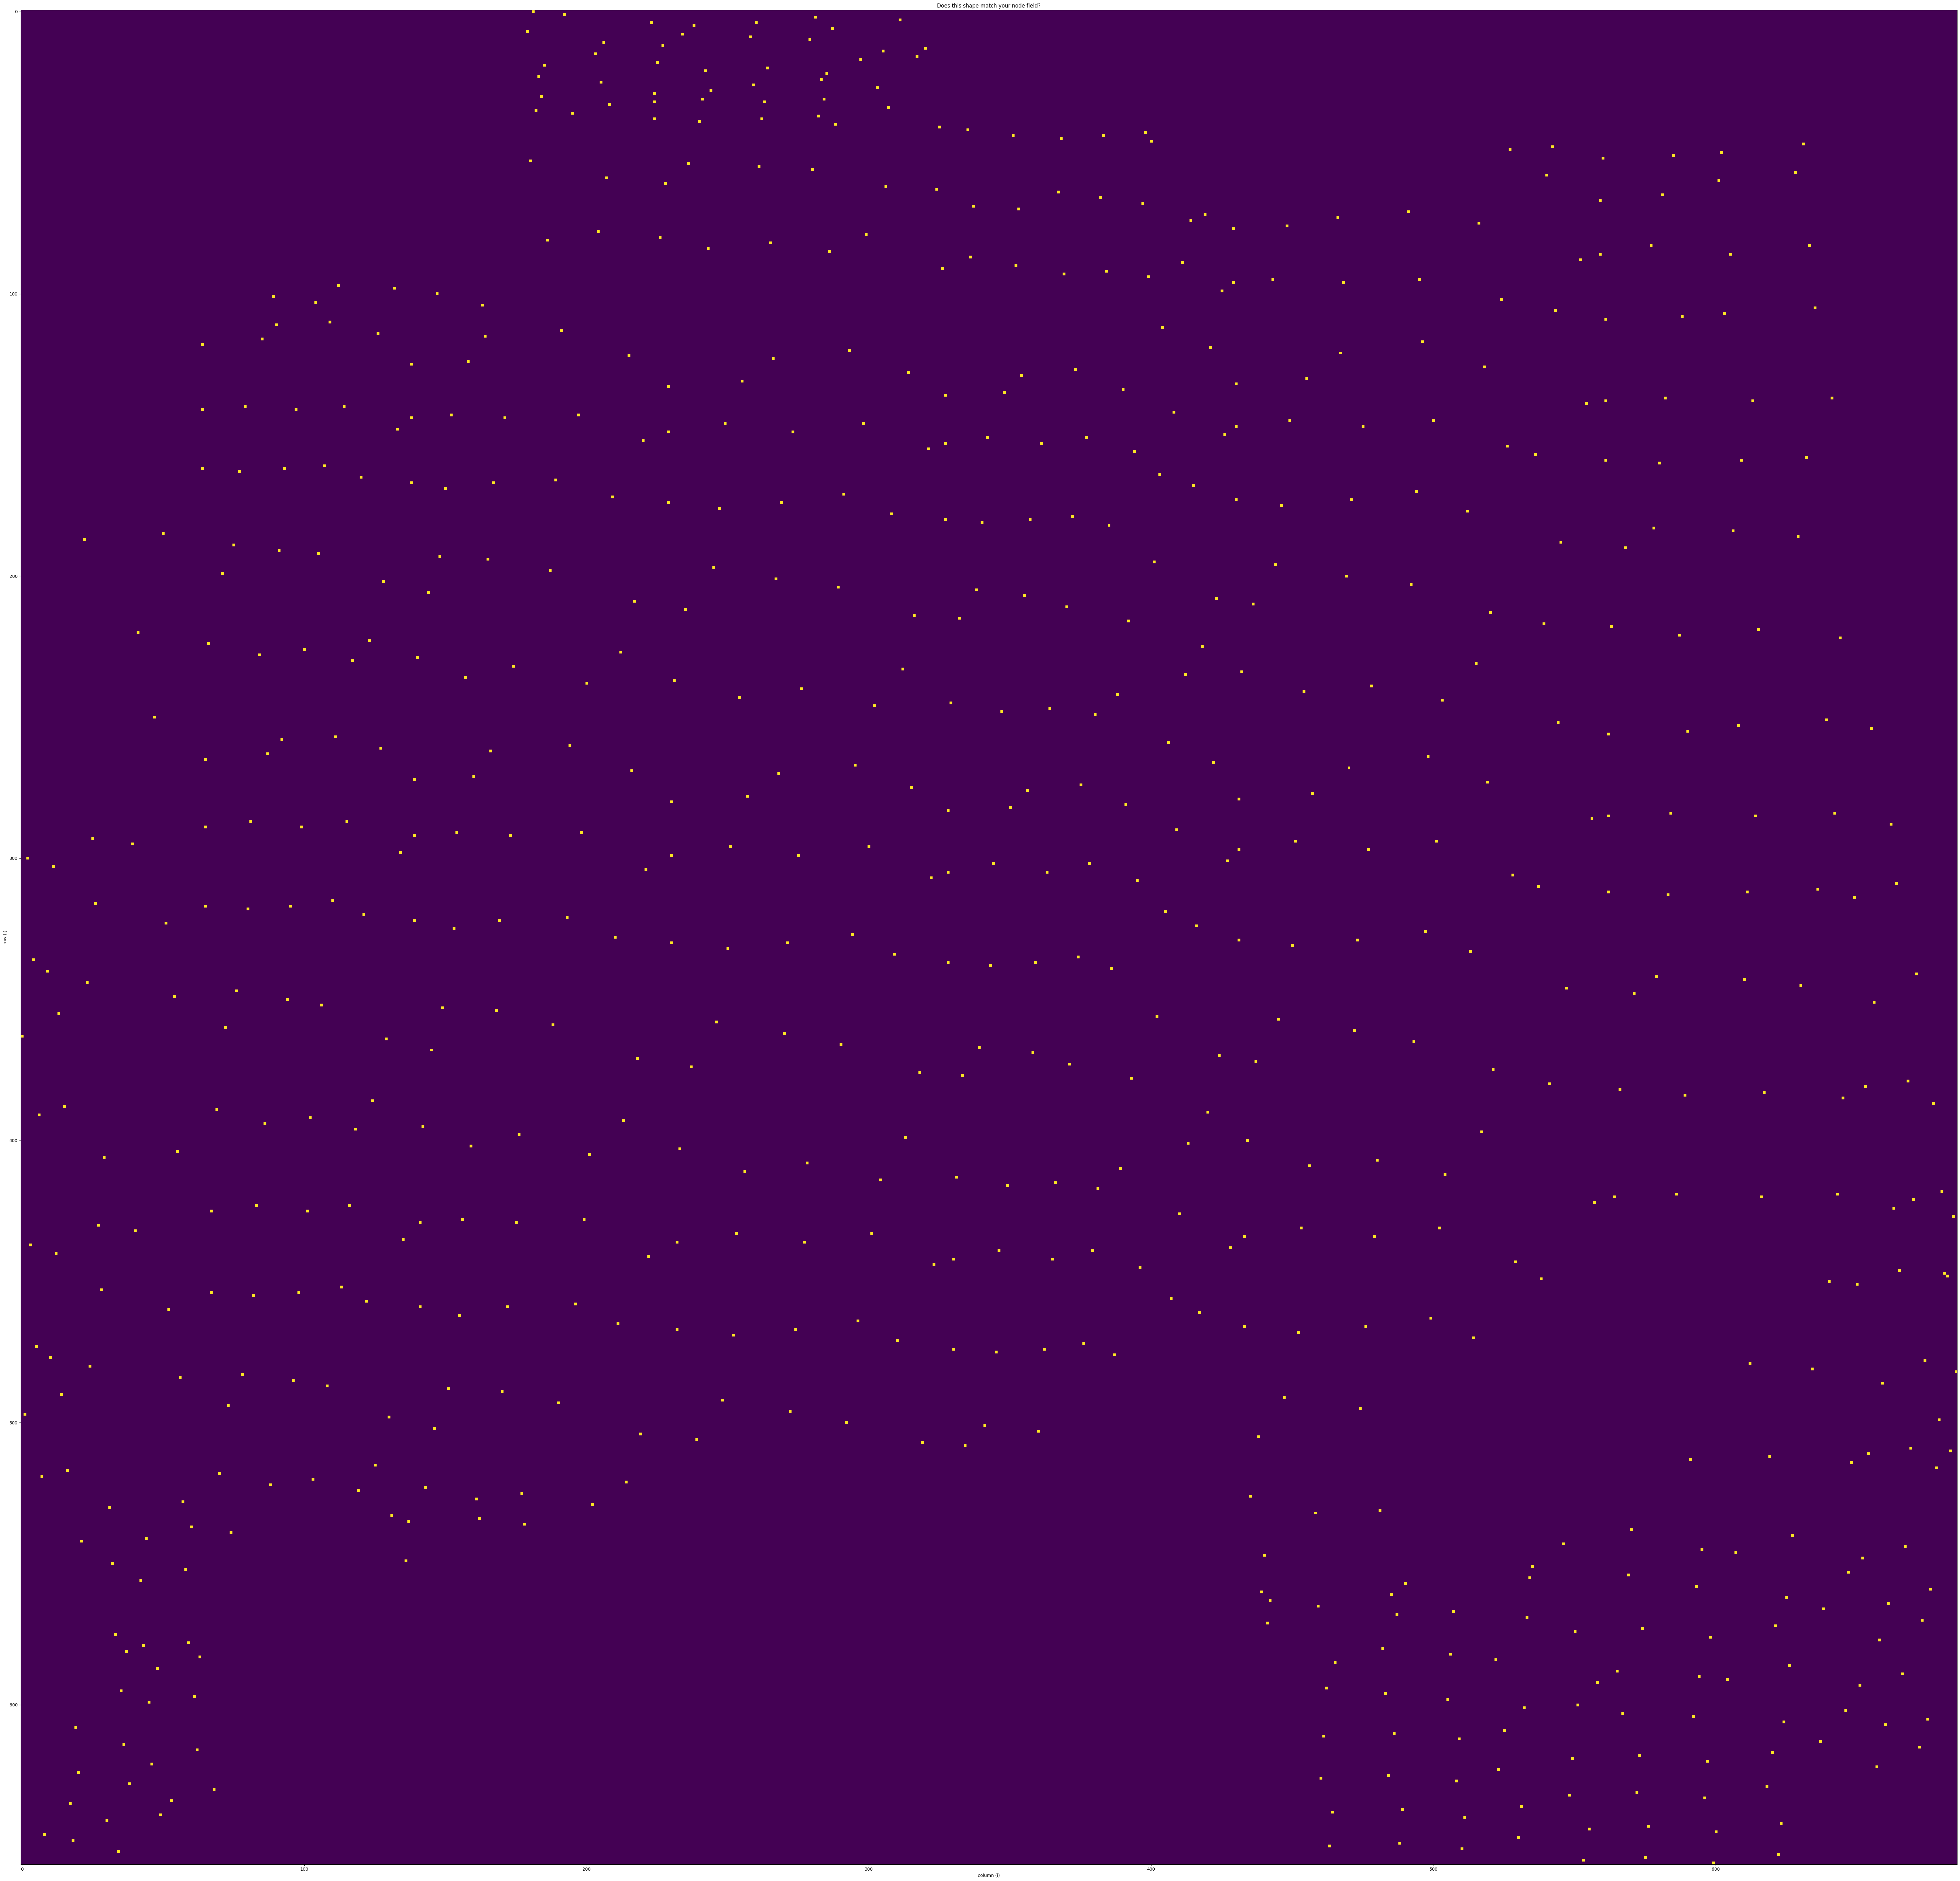

In [2]:
# --- GraphML -> array where node-cells = 0.5, empty cells = -inf ---
# Jupyter-ready. Only needs: lxml, numpy, matplotlib
# pip install lxml numpy matplotlib

from lxml import etree
import numpy as np
import matplotlib.pyplot as plt

def _read_yed_node_centers(graphml_path, round_decimals=6):
    """
    Returns:
      centers: dict[node_id] -> (cx, cy)
      xs: sorted unique list of cx
      ys: sorted unique list of cy
    """
    ns = {
        "g": "http://graphml.graphdrawing.org/xmlns",
        "y": "http://www.yworks.com/xml/graphml",
    }
    tree = etree.parse(graphml_path)
    root = tree.getroot()

    centers = {}
    xs, ys = [], []
    for n in root.xpath(".//g:node", namespaces=ns):
        geom = n.xpath(".//y:Geometry", namespaces=ns)
        if not geom:  # skip group nodes etc.
            continue
        g0 = geom[0]
        x = float(g0.get("x", "0"))
        y = float(g0.get("y", "0"))
        w = float(g0.get("width", "0"))
        h = float(g0.get("height", "0"))
        cx = round(x + w/2.0, round_decimals)
        cy = round(y + h/2.0, round_decimals)
        nid = n.get("id")
        centers[nid] = (cx, cy)
        xs.append(cx); ys.append(cy)

    xs = sorted(set(xs))
    ys = sorted(set(ys))
    return centers, xs, ys

def graphml_to_array(graphml_path, node_value=0.5, empty_value=float("-inf"), round_decimals=6):
    """
    Build a rectangular 2D array from a yEd GraphML where node centers define the grid.
    Array indexing:
      arr[row=j, col=i]  (j corresponds to y; i to x; origin at top-left like yEd)
    Returns:
      arr: 2D numpy array (rows=len(ys), cols=len(xs))
      node_index: dict[node_id] -> (i, j)   # zero-based column/row indices
      xs, ys: the sorted unique coordinate values (useful for debugging/overlays)
    """
    centers, xs, ys = _read_yed_node_centers(graphml_path, round_decimals=round_decimals)
    x_to_i = {x:i for i, x in enumerate(xs)}
    y_to_j = {y:j for j, y in enumerate(ys)}

    arr = np.full((len(ys), len(xs)), empty_value, dtype=float)
    node_index = {}
    for nid, (cx, cy) in centers.items():
        i = x_to_i[cx]
        j = y_to_j[cy]
        arr[j, i] = node_value
        node_index[nid] = (i, j)

    return arr, node_index, xs, ys

def visualize_array_mask(arr, title="Node mask (1 where node, 0 where empty)"):
    """
    Quick visual check: shows a binary mask of where nodes exist.
    """
    mask = (arr != float("-inf")) & np.isfinite(arr)
    plt.figure(figsize=(80, 60))
    plt.imshow(mask.astype(int), origin="upper", interpolation="nearest")
    plt.title(title)
    plt.xlabel("column (i)")
    plt.ylabel("row (j)")
    plt.tight_layout()
    plt.show()


graphml_path = "/home/popsatorn/Desktop/HiMCM_kickoff_2026/code/HIMCM_graph.graphml"


arr, node_index, xs, ys = graphml_to_array(graphml_path, node_value=0.5, empty_value=float("-inf"))


print("Array shape (rows, cols):", arr.shape)
print("Example cell value at a node:", 0.5, "empty:", -np.inf)
visualize_array_mask(arr, title="Does this shape match your node field?")


np.save("grid_from_graph.npy", arr)


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_array_table(arr, title="Grid cells (filled = node)"):
    """
    Table-like plot where cells with a node (finite & != -inf) are filled.
    - arr[j,i] is your rectangular 2D array
    - Works for large grids; uses imshow + gridlines to mimic a table
    """
    arr = np.asarray(arr, float)
    # Node cells = 1, empty = 0
    node_mask = (np.isfinite(arr)) & (arr != float("-inf"))
    Z = node_mask.astype(int)

    fig, ax = plt.subplots(figsize=(200, 150))  # large figure for big grids
    ax.imshow(Z, origin="upper", interpolation="nearest")  # default colormap

    # Make it look like a table: ticks at cell centers + gridlines on boundaries
    nrows, ncols = Z.shape
    ax.set_xticks(np.arange(ncols))
    ax.set_yticks(np.arange(nrows))
    ax.set_xticklabels([str(i) for i in range(ncols)])
    ax.set_yticklabels([str(j) for j in range(nrows)])

    # Gridlines at cell edges
    ax.set_xticks(np.arange(-0.5, ncols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, nrows, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5)

    # Put the x labels on top (table feel)
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


In [8]:
visualize_array_table(arr, title="Does this filled-cell table match my node shape?")
